In [141]:
import numpy as np
import numpy.linalg as npla
import matplotlib.pyplot as plt
from matplotlib import animation


from sympy import exp, sin, diff, symbols
from sympy.utilities.lambdify import lambdify

np.set_printoptions(linewidth=np.inf)

In [142]:
# accuracy and range of x and t
x_i, x_f = (0,1)
t_i, t_f = (0,1)

x_points = 20
t_points = 100

x_delta = (x_f - x_i) / (x_points - 1)
t_delta = (t_f - t_i) / (t_points - 1)

x = np.linspace(x_i, x_f, x_points)
t = np.linspace(t_i, t_f, t_points)

MovieWriter ffmpeg unavailable; using Pillow instead.


0.3646464646464648


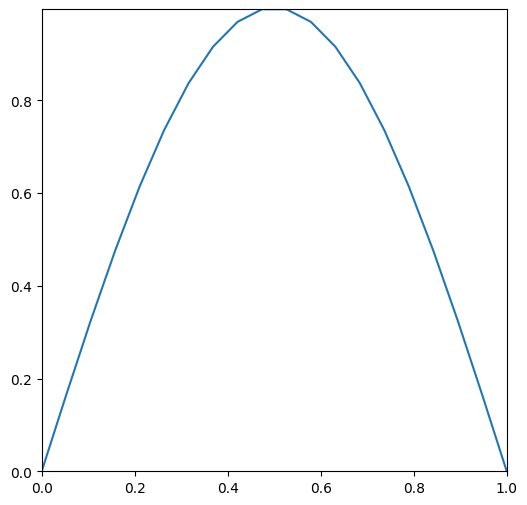

In [143]:
# generating function
x_symbol, t_symbol = symbols('x t')

# heat equation: a * ∇^2 u = du/dt
a = .1

print(a * t_delta / (x_delta ** 2))

phi = sin(np.pi * x_symbol / x_f) * exp(-a * np.pi ** 2 * t_symbol / (x_f ** 2))
phi = np.vectorize(lambdify((x_symbol, t_symbol), phi))

xv, tv = np.meshgrid(x,t)

actual_data = phi(xv,tv)

# plotting the actual data
fig, ax = plt.subplots(1, 1, figsize = (6,6))

max_y = np.max(actual_data)
min_y = np.min(actual_data)

def animate(i):
    ax.cla()
    ax.plot(x, actual_data[i])
    ax.set_xlim((x_i, x_f))
    ax.set_ylim((min_y, max_y))

anim = animation.FuncAnimation(fig, animate, frames = t_points, interval = 2, blit = False)

# I save these gifs on a folder on vscode called tmp. You may have to change this part
anim.save("tmp/actual_solution.gif")

In [144]:
# intial conditions

# heat distribution at t = t_i
f_0 = sin(np.pi * x_symbol / (2 *x_f))
f_0 = np.vectorize(lambdify([x_symbol], f_0))
initial_distribtion = f_0(x)

# x lower boundary condition
x_0 = 0
x_0 = np.vectorize(lambdify([t_symbol], x_0))

# x upper boundary condition
x_L = 1
x_L = np.vectorize(lambdify([t_symbol], x_L))

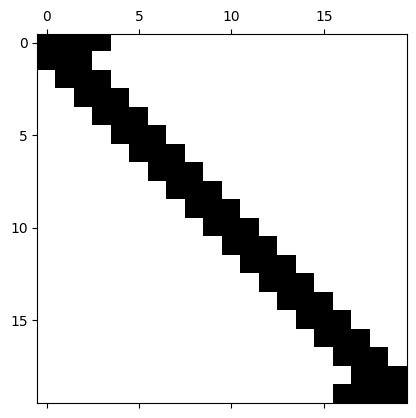

In [145]:
# creating the A matrix
r = a * t_delta / (x_delta ** 2)
rx = r / x_delta

A = np.zeros((x_points, x_points))

# old method of creating A with the r term baked into it
# A[0, 0:4] = (1 + 2 * rx, -5 * rx, 4 * rx, -1 * rx)
# for i in range(1, x_points - 1): A[i, i-1:i+2] = (r, 1 - 2 * r, r)
# A[-1, -4:] = (-1 * rx, 4 * rx, -5 * rx, 1 + 2 * rx)

A[0, 0:4] = (r + 2 / x_delta, -5 / x_delta, 4 / x_delta, -1 / x_delta)
for i in range(1, x_points - 1): A[i, i-1:i+2] = (1, r - 2, 1)
A[-1, -4:] = (-1 / x_delta, 4 / x_delta, -5 / x_delta, r + 2 / x_delta)

def laplacian_1d(points : int, delta : float):
    mat = np.zeros((points, points))
    for i in range(1, points - 1): mat[i, i-1:i+2] = (1,-2,1)
    mat *= delta
    
    mat[0][0:4] = (2,-5,4,-1)
    mat[-1][-4:] = (-1,4,-5,2)

    return mat / (delta ** 3)

A = laplacian_1d(x_points, x_delta)

plt.spy(A)

In [146]:
# prolongation and restriction matrices
P = np.zeros((x_points, x_points - 2))
P[1:-1,0:] = np.eye(x_points - 2)
R = P.transpose()

In [147]:
# saving the value of RAP ^ -1 so I don't have to recalculate it
RAP_inv = npla.inv(R @ A @ P)
RAP = R @ A @ P

# setting up the u points
u = initial_distribtion
u_mat = np.zeros((t_points, x_points))
u_mat[0] = u

# used for looping
index = 0

# iteratively applies the A matrix
for curr_time in t[:-1]:
    curr_bc  = np.zeros(x_points)
    curr_bc[0] = x_0(curr_time)
    curr_bc[-1] = x_L(curr_time)

    # old attempt (this is what I meant by going backward)
    # u = RAP_inv @ (R @ (u - (A @ curr_bc)))
    # u = P @ u + curr_bc

    # old attempt (for having r baked into the A matrix)
    # u = u - t_delta * A @ u
    u += a * t_delta * A @ u

    # I'm still not sure why this works: I get why the u, r and A are there, but I don't understand why there is a t_delta term (since that is included in the r term?)
    # Since r = a * t_delta / (x_delta ** 2), the t_delta would end up cancelling. 

    u[0] = x_0(curr_time)
    u[-1] = x_L(curr_time)

    u_mat[index := index + 1] = u

MovieWriter ffmpeg unavailable; using Pillow instead.


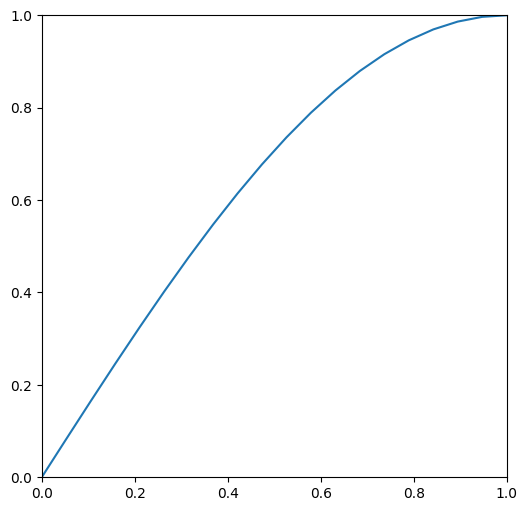

In [148]:
# plotting my solution
fig, ax = plt.subplots(1, 1, figsize = (6,6))

max_y = np.max(u_mat)
min_y = np.min(u_mat)

def animate(i):
    ax.cla()
    ax.plot(x, u_mat[i])
    ax.set_xlim((x_i, x_f))
    ax.set_ylim((min_y, max_y))

anim = animation.FuncAnimation(fig, animate, frames = t_points, interval = 2, blit = False)
anim.save("tmp/approximate_solution.gif")

In [149]:
a * t_delta / (x_delta ** 2)

0.3646464646464648

In [150]:
# comparing accuracy

# I add this so the program doesn't give me a divide by zero error later
u_mat += 1e-15
actual_data += 1e-15

# making sure the percent accuaracy is within some threshold
print(abs(u_mat - actual_data) / actual_data < .005)


u_mat -= 1e-15
actual_data -= 1e-15

[[ True False False ... False False False]
 [ True False False ... False False False]
 [ True False False ... False False False]
 ...
 [ True False False ... False False False]
 [ True False False ... False False False]
 [ True False False ... False False False]]
